## Imports

In [1]:
#Python3.10
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from dataretrieval import nwis, utils, codes

c:\Users\alekh\AppData\Local\Programs\Python\Python310\lib\site-packages\dataretrieval\nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


## Inputs

In [43]:
# 11447650 -- Sacramento River Basin
# 11303500 -- San Joaquin-Tulare Basin
# SRB -- '1970-01-01' '2014-01-01'
# SJTB -- '1989-01-01' '2014-01-01'
# Water year -- Oct 1-Sept 30

class StreamGuage:
    def __init__(self, id, mean_start_date, mean_end_date, post_start_date, post_end_date):
        self.id = id
        # Start date for all-time mean daily flow data
        self.mean_start_date = mean_start_date
        self.mean_end_date = mean_end_date
        # Start date for post-impairment mean daily flow data
        self.post_start_date = post_start_date
        self.post_end_date = post_end_date
        
SRB_Guage = StreamGuage('11447650', '1948-10-01', '2014-09-30', '1970-10-01', '2014-09-30')
SJTB_Guage = StreamGuage('11303500', '1923-10-01', '2014-09-30', '1989-10-01', '2014-09-30')

# Change this to modify analysis values
curr_guage = SJTB_Guage

SITE_NO = '11303500'
STATE_CODE = 'ca'
START_DATE = '1970-10-30'
END_DATE = '2014-09-30'
SERVICE = 'dv'

# Location Hydrological Year
HYDRO_YEAR = 'AS-OCT'

# 00060 -- Discharge
# 00010 -- Temperature
PARAM_CODE = '00060'

# ft^3 -> km^3
CUBIC_FT_KM_FACTOR = 0.0000000000283168466
SEC_PER_YEAR = 31536000 
SEC_PER_DAY = 86400

## Data Retrieval<br>
<p>This is using average cubic feet per second discharge per day</p> 

In [44]:
# df2 holds all-time data, df is analyzed range
df = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.post_start_date, end=curr_guage.post_end_date)
df2 = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.mean_start_date, end=curr_guage.mean_end_date)
df = df.reset_index()
df2 = df2.reset_index()
#df2.to_csv('srb_full.csv')

# For ease of quantile calculation
df_mean = pd.DataFrame(df2['00060_Mean'])

# 90th percentile calculation
threshold_90 = df_mean.quantile(q=0.90, axis=0).iloc[0]
print(f'90%: {threshold_90}')

hmf_series = df[df['00060_Mean'] > threshold_90]
#hmf_series = hmf_series.to_frame()
#hmf_series.to_csv('hmf.csv')

# Find number of years with HMF 
df['datetime'] = pd.to_datetime(hmf_series['datetime'])
df.set_index('datetime', inplace=True)
df['offsetdate'] = df.index - pd.offsets.YearBegin(month=10)
hmf_years = df['offsetdate'].dt.year.nunique()
print(f'HMF Years: {hmf_years}')

# Mask out months that don't fall within 3 and 6 month Winter range
hmf_series.loc[:, 'datetime'] = pd.to_datetime(hmf_series['datetime'])
six_month_mask = (hmf_series['datetime'].dt.month >= 11) | (hmf_series['datetime'].dt.month <= 4)
three_month_mask = (hmf_series['datetime'].dt.month >= 12) | (hmf_series['datetime'].dt.month <= 2)

df_six_month = hmf_series[six_month_mask]
df_three_month = hmf_series[three_month_mask]

# Convert to daily average flow in cfps, and take only flow above the threshold
hmf_series = (hmf_series['00060_Mean'] - threshold_90) * SEC_PER_DAY
total_hmf_flow = hmf_series.sum()
print(f'Total Volume of HMF: {total_hmf_flow}')

# Calculate 3 and 6 month HMF
df_six_month = (df_six_month['00060_Mean'] - threshold_90) * SEC_PER_DAY
six_month_hmf = df_six_month.sum()
df_three_month = (df_three_month['00060_Mean'] - threshold_90) * SEC_PER_DAY
three_month_hmf = df_three_month.sum()

print(f'Total HMF in CKPY: {((total_hmf_flow * CUBIC_FT_KM_FACTOR) / hmf_years)}')
print(f'Six Month HMF in CKPY: {((six_month_hmf * CUBIC_FT_KM_FACTOR) / hmf_years)}')
print(f'Three Month HMF in CKPY: {((three_month_hmf * CUBIC_FT_KM_FACTOR) / hmf_years)}')


90%: 11600.0
HMF Years: 9
Total Volume of HMF: 514918080000.0
Total HMF in CKPY: 1.6200951425473922
Six Month HMF in CKPY: 1.187513401799424
Three Month HMF in CKPY: 0.5461300302662401


## Data Visualization<br>

Rows: 47
Correlation: 0.6181660900296607


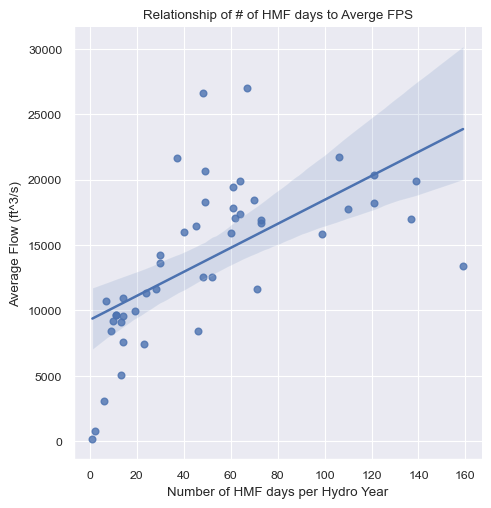

Rows: 39
Correlation w/No Outliers: 0.7340109778858693


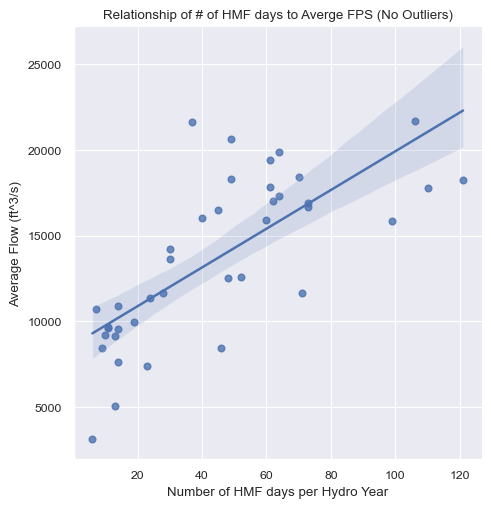

In [40]:
# Scatter plot looking at correlation between # of HMF days per hydrologic year, and average daily flow 
df = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.mean_start_date, end=curr_guage.mean_end_date)
hmf_series = df[df['00060_Mean'] > threshold_90]
hmf_series = hmf_series['00060_Mean'] - threshold_90
#hmf_series.to_csv('hmf_series.csv')
hmf_series = pd.DataFrame(hmf_series)
#hmf_series.set_index('datetime', inplace=True)

# Aggregate dataframe by total flow per day per hydro year, and # of HMF days per hydro year
df_results = hmf_series.resample(HYDRO_YEAR).agg({'00060_Mean': ['sum', 'count']})
df_results.columns = ['Sum', 'Count']

# Remove all hydrologic years with no HMF and calculate average FPS/per day
df_results = df_results[df_results['Count'] != 0]
df_results['Average FPS'] = df_results['Sum'] / df_results['Count']
print(f'Rows: {len(df_results)}')

# Correlation
corr = df_results['Count'].corr(df_results['Average FPS'])
print(f'Correlation: {corr}')

# Data Plotting

#plt.figure(figsize=(6, 6))
sns.set(color_codes=True)
sns.set_context('paper')

sns.lmplot(data=df_results, x='Count', y='Average FPS')
plt.xlabel('Number of HMF days per Hydro Year')
plt.ylabel('Average Flow (ft^3/s)')
plt.title('Relationship of # of HMF days to Averge FPS')
plt.show()

# Remove outliers w/Z-score
z_scores = np.abs((df_results - df_results.mean()) / df_results.std())
#print(z_scores)

# Somewhat arbitrary threshold that removes just the most egregious outliers
threshold = 2
df_results_no = df_results[(z_scores <= threshold).all(axis=1)]

print(f'Rows: {len(df_results_no)}')
# Correlation no outliers
corr_no = df_results_no['Count'].corr(df_results_no['Average FPS'])
print(f'Correlation w/No Outliers: {corr_no}')

#plt.figure(figsize=(6, 6))
sns.lmplot(data=df_results_no, x='Count', y='Average FPS')
plt.xlabel('Number of HMF days per Hydro Year')
plt.ylabel('Average Flow (ft^3/s)')
plt.title('Relationship of # of HMF days to Averge FPS (No Outliers)')
plt.show()

## Mapping<br>

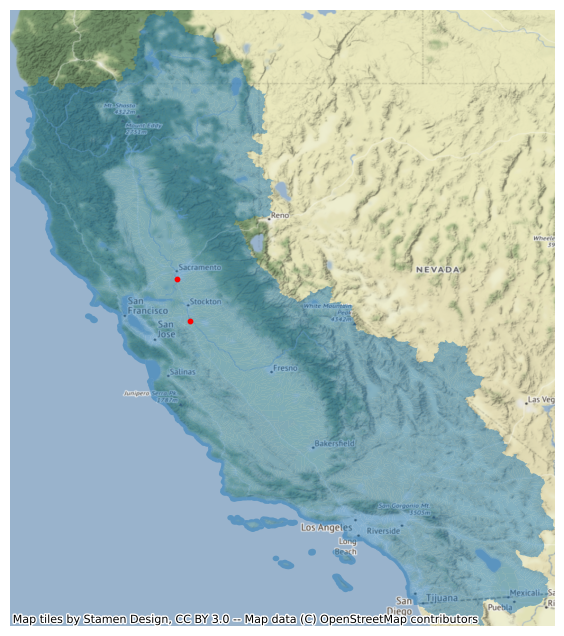

In [75]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx

shape = gpd.read_file('ShapeFiles/CA/Shape/WBDHU12.shp')
#print(shape.crs)

df = nwis.get_record(sites=SITE_NO, service='site')
df2 = nwis.get_record(sites='11303500', service='site')
lat = [df['dec_lat_va'].iloc[0], df2['dec_lat_va'].iloc[0]]
long = [df['dec_long_va'].iloc[0], df2['dec_long_va'].iloc[0]]

fig, ax = plt.subplots(figsize=(8, 8))
ax.margins(0)
shape.plot(ax=ax, alpha=0.50)

geometry = [Point(xy) for xy in zip(long, lat)]
geo_df = gpd.GeoDataFrame(geometry=geometry)

bx = geo_df.plot(ax=ax, markersize=40, color='red', marker='.', label='CA Watershed')
#bx.set_title("WBDHU8")
bx.margins(0, tight=True)
bx.set_axis_off()
cx.add_basemap(bx, crs=shape.crs)